In [1]:
using Random, Distributions, Statistics, DataFrames # w terminalu wpisac julia, potem ] i komenda np. add DataFrames

h = 0.1 #storage cost
c = 2.0 #unit profit
p = 0.50 #probability of delivery
K = 40 # fixed order cost
k = 1.0 # variable order cost
##można zostawić to albo zmienić na wybrane 
average_demand = 20

s = 30
S = 50 
#będziemy szukać takich s, które dają największy profit

X = 100  # poczatek dnia pierwszego symulacji
profit = 0.0 

0.0

In [2]:
pois = Distributions.Poisson(average_demand)
##wadą jest mała wariancja, w rzeczywistości popoyt jest bardziej chaotyczny
##można wybrac inny rozkład, żeby to urealnić, np normalny....

Poisson{Float64}(λ=20.0)

In [3]:
rand(pois, 5)

5-element Vector{Int64}:
 20
 25
 24
 20
 23

In [4]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
## będziemy iterować te funkjce przez s, S, a 'm' to liczba dni
## 
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    pois = Distributions.Poisson(average_demand)
    for day in 1:m
        if Xⱼ < s  # reorder point
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        demand = rand(pois)
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        ## mozna dodac one_objective = 0.75 * profit + 0.01 *lost_orders
        ## albo można przemnozyc przez paramter koszst jednostkowy stckoutu
        ## k_jedn_stockout = 
        ## ne_objective = 0.75 * profit + 0.01 *lost_orders * k_jedn_stockout
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels)
    ## wtedy ....(profit=profit, lost_orders=lost_orders,
    ##    warehouse_levels=warehouse_levels one_objective=one_objective)
    
end

simulateOneRun (generic function with 1 method)

In [5]:
res = simulateOneRun(20,20,200)
## przykładowe wykonanie funkjci
## jak każdego dnia kształtował się warehouse warehouse_levels - patrzymy jak wyglądał stan magazynu i dostawy do niego
## możwe że tu nie powinno być '200' -> możliwy błąd

(profit = 848.1000000000001, lost_orders = 24.0, warehouse_levels = [100, 84, 68, 36, 22, 7, 200, 175, 156, 136, 122, 99, 78, 61, 37, 16, 200, 181, 155, 134])

In [6]:
@show res.profit
@show res.lost_orders
@show res.warehouse_levels;

res.profit = 848.1000000000001
res.lost_orders = 24.0
res.warehouse_levels = [100, 84, 68, 36, 22, 7, 200, 175, 156, 136, 122, 99, 78, 61, 37, 16, 200, 181, 155, 134]


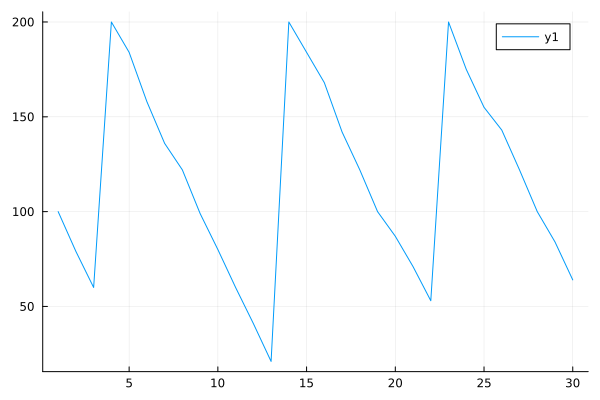

In [8]:
Random.seed!(10)
res = simulateOneRun(30,50,200)

# using PyPlot
# plot(res.warehouse_levels)
# show()
using Plots
plot(res.warehouse_levels)

In [9]:
res = DataFrame(simulateOneRun(10,5,10) for n in 1:4)

,profit,lost_orders,warehouse_levels
,Float64,Float64,Array…
1,114.6,68.0,"[100, 81, 62, 39, 12, 10, 0, 10, 10, 10]"
2,186.5,88.0,"[100, 77, 52, 28, 8, 10, 0, 0, 10, 10]"
3,322.1,93.0,"[100, 76, 52, 36, 20, 5, 0, 0, 10, 0]"
4,49.6,55.0,"[100, 70, 52, 30, 2, 10, 10, 10, 10, 10]"


In [10]:

## srednie stockouty lost_mean
## 
function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end


run_sims(30,50,100)

(m = 30, s = 50, S = 100, N = 100, profit_mean = 965.1360000000001, profit_std = 109.34252688619642, lost_mean = 40.29, lost_std = 39.1596821625343)

In [11]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(90,s,S,100) 
    for S in 100:100:1000, s in 25:25:250 if S > s )

,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,25,100,100,2971.25,187.955,216.66,86.947
2,90,25,200,100,3579.8,143.172,118.92,62.0491
3,90,25,300,100,3488.41,233.743,81.2,61.1899
4,90,25,400,100,3081.23,179.821,60.11,45.8938
5,90,25,500,100,2630.79,167.024,50.72,46.5774
6,90,25,600,100,2546.72,258.47,34.57,38.6717
7,90,25,700,100,1683.64,168.939,33.52,31.9461
8,90,25,800,100,1200.97,281.166,32.05,34.9673
9,90,25,900,100,1367.4,302.588,30.45,37.8336


In [12]:
best_row = argmax(df.profit_mean)

2

In [13]:
df[best_row,:]

,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
2,90,25,200,100,3579.8,143.172,118.92,62.0491


In [14]:
findall(<=(-500), df.profit_mean)'


1×4 adjoint(::Vector{Int64}) with eltype Int64:
 66  74  82  90

In [15]:
df[66,:]

,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
66,90,175,1000,100,-507.847,446.965,1.49,9.63002


In [16]:
df[[66, 74,82,90],:]

,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,175,1000,100,-507.847,446.965,1.49,9.63002
2,90,200,1000,100,-772.374,332.434,0.52,5.2
3,90,225,1000,100,-954.18,197.85,1.32,7.08517
4,90,250,1000,100,-1019.13,171.746,0.0,0.0


In [17]:
df[findall(<=(-500), df.profit_mean),:]

,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,175,1000,100,-507.847,446.965,1.49,9.63002
2,90,200,1000,100,-772.374,332.434,0.52,5.2
3,90,225,1000,100,-954.18,197.85,1.32,7.08517
4,90,250,1000,100,-1019.13,171.746,0.0,0.0


In [18]:
more500 = findall(>(-500), df.profit_mean)'

1×86 adjoint(::Vector{Int64}) with eltype Int64:
 1  2  3  4  5  6  7  8  9  10  11  12  …  80  81  83  84  85  86  87  88  89

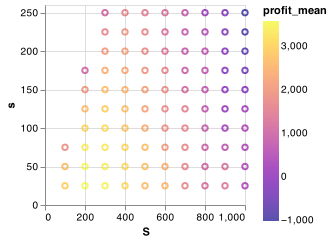

In [19]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

# scatter(df.S[more500],
#         df.s[more500], 
#         c=df.profit_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Profits")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()

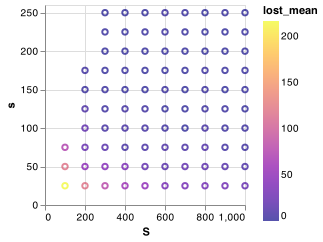

In [20]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:lost_mean, scale={scheme=:plasma}})

        # scatter(df.S[more500],
#         df.s[more500], 
#         c=df.lost_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Lost orders")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()
# savefig(raw"c:\temp\lost_orders.png")

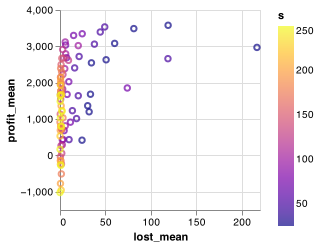

In [21]:
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:s, scale={scheme=:plasma}})

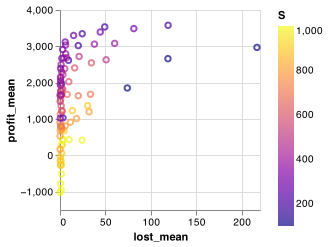

In [22]:
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:S, scale={scheme=:plasma}})